In [7]:
from tensorflow.keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Fetch Dataset to train on
- use tensorflow's dataset api to grab dataset
- Training shape - 50000, 32 ,32, 3
- Testing shape - 10000, 32, 32, 3

In [8]:
(X_train, y_train), (X_test, y_test) = load_data()
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(X_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


# Convolutional Nueral Network
- Overview: 
    1. Clean data
    1. Create architecture
    1. Tune hyperparameters
    1. Train model
    1. Evaluate

## How to clean data
1. normalize data
1. augment training dataset

In [10]:
# Training set for convolutional neural network
(X_train_cnn, y_train_cnn), (X_test_cnn, y_test_cnn) = (X_train, y_train), (X_test, y_test)

## Normalize data to values between 0 and 1
- Optimize data for nueral network
- divide all pixels by max value(255.0)

In [11]:
X_train_cnn, X_test_cnn = X_train_cnn/255.0, X_test_cnn/255.0

## Augment training dataset to 100,000 
- Using tensorflow's api, augment dataset
- Randomly flip and rotate images
- Add augmented images to dataset, thereby doubling

In [12]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

/tmp/ipykernel_15/589828527.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temp_test[i*2], temp_test[i*2+1] = y_train_cnn[i],y_train_cnn[i]


(100000,)
(100000, 32, 32, 3)


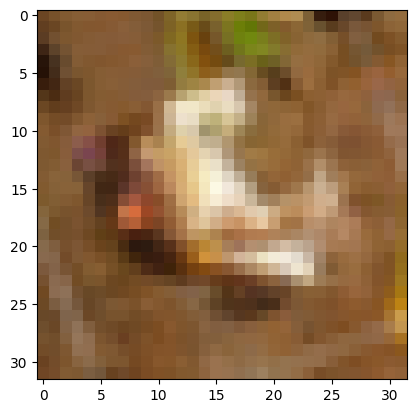

In [13]:
# plt.figure(figsize=(10, 10))
# image = X_train_cnn[5]
# print(image.shape)

# augmented_image = data_augmentation(image)
# ax = plt.subplot(3, 3, 2)
# plt.imshow(augmented_image)
# plt.axis("off")
# print(augmented_image.shape)

temp_train = np.zeros((100000, 32,32,3))
temp_test = np.zeros(100000)
for i in range(X_train_cnn.shape[0]):
    image = X_train_cnn[i]
    augmented_image = data_augmentation(image)
    temp_train[i*2] = X_train_cnn[i]
    temp_train[i*2+1] = augmented_image
    temp_test[i*2], temp_test[i*2+1] = y_train_cnn[i],y_train_cnn[i]

print(temp_test.shape)
print(temp_train.shape)


plt.imshow(temp_train[1])

## Image of frog:
- Original kept
- New, rotated/flipped image added
- Training model more on abstract shapes

6.0
6.0


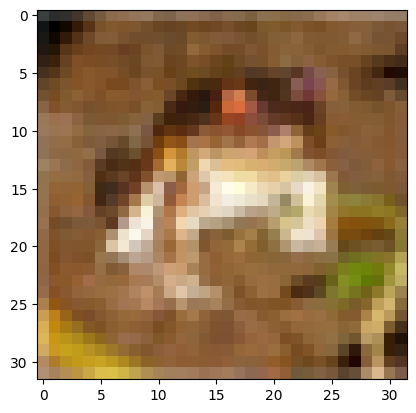

In [14]:
plt.imshow(temp_train[0])
print(temp_test[0])
print(temp_test[1])

## Set our training set to temp and delete temp

In [17]:
X_train_cnn = temp_train
y_train_cnn = temp_test

print(y_train_cnn[0])
print(y_train_cnn[1])

6.0
6.0


In [18]:
del temp_test
del temp_train

## Nueral Network Architecture
- Implement Alexnet inspired Architecture
- Hyperparameters to tune
    1. First convolutional layer window size
    1. First, second layers filter size
    1. First and second dense layers
- Architecture inspired by Alexnet CNN


In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout
import keras_tuner

def build_model(hp):
    conv_layer_1_kernel = hp.Choice('conv_layer_1_kernel', [5,7])
    conv_layer_1_filters = hp.Choice('conv_layer_1_filters', [32,64])
    pool_layer_1 = hp.Choice('pool_layer_1', [2,3])
    pool_layer_2 = hp.Choice('pool_layer_2', [2,3])
    dense_layer_1 = hp.Int('dense_layer_1', min_value=1024, max_value=2048, step=512)
    dense_layer_2 = hp.Int('dense_layer_2', min_value=128, max_value=256, step=64)
    # First Convolution layer
    model = tf.keras.Sequential()
    model.add(Input(shape=(32,32,3)))
    model.add(Conv2D(filters=conv_layer_1_filters, kernel_size=(conv_layer_1_kernel,conv_layer_1_kernel),padding='same', activation='relu'))
    
    # First pooling layer
    model.add(MaxPooling2D(pool_size=(pool_layer_1, pool_layer_1)))

    # Second conv layer
    model.add(Conv2D(filters=conv_layer_1_filters*2, kernel_size=(conv_layer_1_kernel,conv_layer_1_kernel),padding='valid', activation='relu'))

    # Second pooling layer
    model.add(MaxPooling2D(pool_size=(pool_layer_2, pool_layer_2)))

    # Flatten parameters
    model.add(Flatten())

    # Dense Layer 1
    model.add(Dense(dense_layer_1,activation='relu'))

    # Dropout layer 1 - prevent over fitting
    model.add(Dropout(.5))

    # Dense layer 2
    model.add(Dense(dense_layer_2,activation='relu'))

    # Final output
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model




2024-04-10 10:42:44.263534: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 10:42:44.385408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Uses randomsearch to find best hyper parameters for model

In [19]:
tuner = keras_tuner.RandomSearch(
    hypermodel = build_model,
    objective='val_accuracy',
    max_trials=5,
    project_name="new_machine",
    overwrite=True
    )

In [20]:

tuner.search(X_train_cnn[:90000], y_train_cnn[:90000], epochs=5, validation_data=(X_train_cnn[90000:], y_train_cnn[90000:], early_stop))


Trial 5 Complete [00h 00m 34s]
val_accuracy: 0.5200999975204468

Best val_accuracy So Far: 0.5735999941825867
Total elapsed time: 00h 02m 34s


In [ ]:
print(tuner.results_summary())
best_model = tuner.get_best_models()[0]

## Using early stopping, train CNN with best hyper parameters

In [53]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
)
history = best_model.fit(X_train_cnn,y_train_cnn,validation_split=.2, epochs=50, callbacks=[early_stop])

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8941 - loss: 0.3198 - val_accuracy: 0.9650 - val_loss: 0.1287
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9000 - loss: 0.3041 - val_accuracy: 0.9499 - val_loss: 0.1644
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9017 - loss: 0.2997 - val_accuracy: 0.9543 - val_loss: 0.1554
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9025 - loss: 0.2969 - val_accuracy: 0.9157 - val_loss: 0.2582


In [54]:
y_pred = best_model.predict(X_test_cnn)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [55]:
y_pred = np.argmax(y_pred, axis=1)

In [56]:
y_pred.shape

(10000,)

## CNN Metrics

In [57]:
import sklearn
print('Accuracy: ',best_model.evaluate(X_test_cnn,y_test_cnn, verbose=0)[1])
print('F1_score: ',sklearn.metrics.f1_score(y_test_cnn, y_pred, average='macro'))
print('Recall Score: ',sklearn.metrics.recall_score(y_test_cnn, y_pred, average='macro'))
print('Precision Score:',sklearn.metrics.precision_score(y_test_cnn, y_pred, average='macro'))

Accuracy:  0.6883000135421753
F1_score:  0.6867024782598757
Recall Score:  0.6883000000000001
Precision Score: 0.6894279640778486


<Axes: >

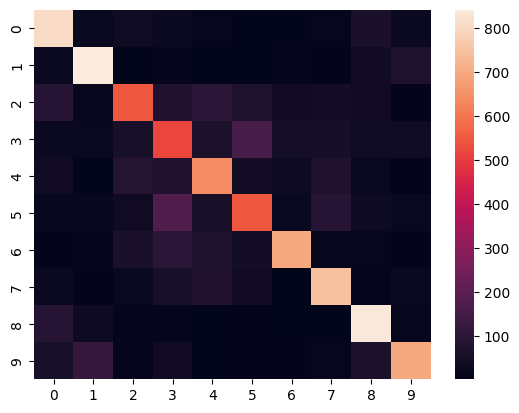

In [58]:
import seaborn as sns
conf_matrix = sklearn.metrics.confusion_matrix(y_test_cnn, y_pred)
sns.heatmap(conf_matrix, )

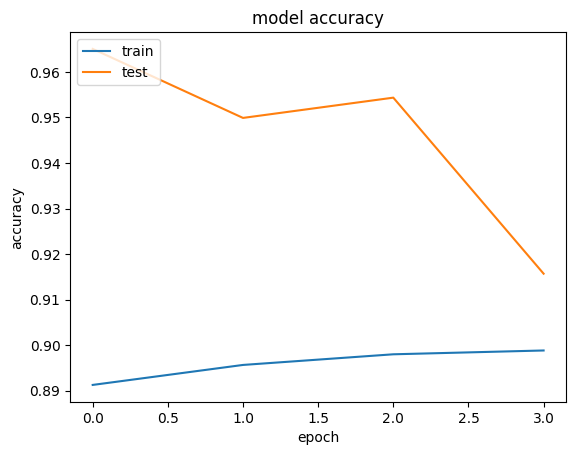

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

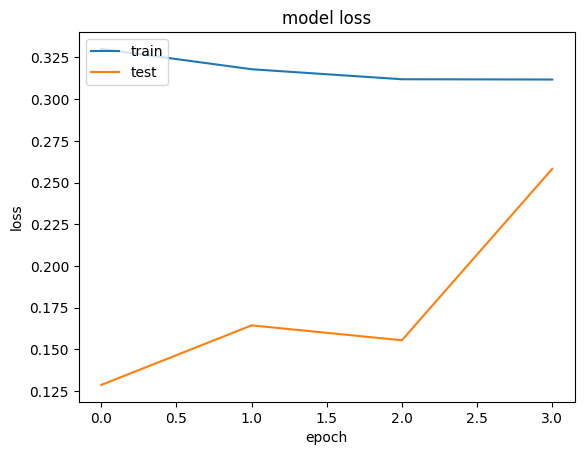

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# CNN Conclusion
- Using hyper parameters tuning we found the best parameters for architecture above
- Using early stopping, we were able to train model efficiently
- Metrics:
    1. Accuracy:  0.6883000135421753
    1. F1_score:  0.6867024782598757
    1. Recall Score:  0.6883000000000001
    1. Precision Score: 0.6894279640778486
- Plots
    1. We found that the accuracy for test went down and test loss went up
    1. Indicates overfitting

# K-neighbors classifier
- Overview:
    1. Clean data for K-neighbors
    1. Hyperparameter tune model
    1. Train model
    1. Test and evaluate

## Clean Data for K-neighbors classifier
- For K nearest neighbors
    1. grayscale data
    1. normlize data
    1. reshape to 1d array

(10000, 32, 32)


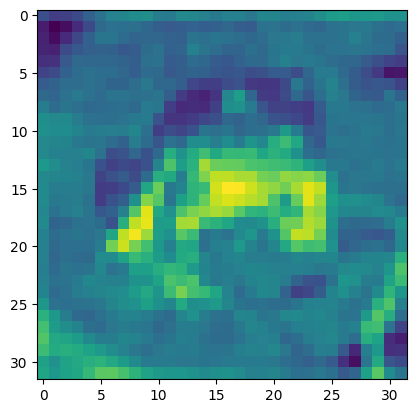

In [61]:
from skimage import data
from skimage.color import rgb2gray
# go through dataset
# set all images to grayscale
X_train_knn = np.zeros((50000,32,32))
X_test_knn = np.zeros((10000,32,32))
for i in range(X_train.shape[0]):
    X_train_knn[i] = rgb2gray(X_train[i])
for i in range(X_test.shape[0]):
    X_test_knn[i] = rgb2gray(X_test[i])

X_train_knn = X_train_knn/255.0
X_test_knn = X_test_knn/255.0
print(X_test_knn.shape)
plt.imshow(X_train_knn[0])

In [62]:
# reshape images
X_train_knn.reshape((50000,32*32)).shape

(50000, 1024)

In [63]:
# Normalize data
X_train_knn = X_train_knn/255.0
X_test_knn = X_test_knn/255.0

In [86]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X = X_train_knn.reshape((50000,32*32)), y=y_train.reshape(50000))

KNeighborsClassifier()

In [87]:
y_pred = model.predict(X_test_knn.reshape((10000,32*32)))

In [88]:
y_pred

array([2, 8, 8, ..., 5, 5, 0], dtype=uint8)

In [89]:
y_test.shape

(10000, 1)

## KNN metrics
- Confusion Matrix
- Precision, Recall, F1 score, Accuracy

<Axes: >

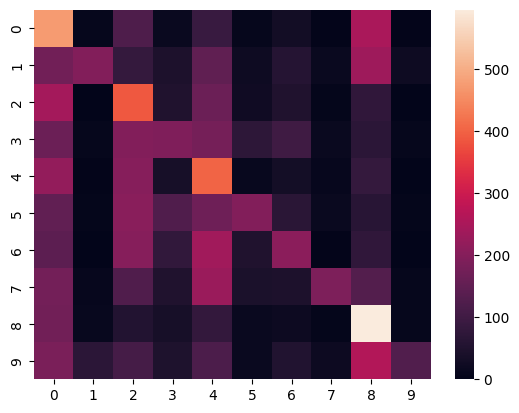

In [90]:
from sklearn.metrics import confusion_matrix
import seaborn
confusion_matrix = confusion_matrix(y_test, y_pred.reshape(10000,1))

seaborn.heatmap(confusion_matrix)

In [91]:
import sklearn.metrics

print('Accuracy: ',sklearn.metrics.accuracy_score(y_pred=y_pred.reshape(10000,1), y_true=y_test))
print('F1 Score: ',sklearn.metrics.f1_score(y_pred=y_pred.reshape(10000,1), y_true=y_test, average='weighted'))
print('Precision: ',sklearn.metrics.precision_score(y_pred=y_pred.reshape(10000,1), y_true=y_test, average='weighted'))
print('Recall: ',sklearn.metrics.recall_score(y_pred=y_pred.reshape(10000,1), y_true=y_test, average='weighted'))

Accuracy:  0.2963
F1 Score:  0.2854845178063419
Precision:  0.4010418775150852
Recall:  0.2963


## It is not very good, lets do some hyperparameter tuning

In [93]:

from sklearn.model_selection import GridSearchCV
param_grid = [
  { 
      'n_neighbors': [3,5],
      'weights': ['uniform', 'distance']
  }
]

model = KNeighborsClassifier()

gridSearch = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, scoring="accuracy", verbose=1)


In [95]:
gridSearch.fit(X_train_knn.reshape(50000,32*32), y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 5],
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy', verbose=1)

In [97]:
gridSearch.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [100]:
new_model = KNeighborsClassifier(n_neighbors=3, weights='distance')

new_model.fit(X=np.reshape(X_train_knn, (50000,32*32)), y=np.reshape(y_train, (50000)))

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [104]:
y_pred_knn = new_model.predict(X=np.reshape(X_test_knn, (10000,32*32)))

In [105]:
print('Accuracy: ',sklearn.metrics.accuracy_score(y_pred=y_pred_knn.reshape(10000,1), y_true=y_test))
print('F1 Score: ',sklearn.metrics.f1_score(y_pred=y_pred_knn.reshape(10000,1), y_true=y_test, average='weighted'))
print('Precision: ',sklearn.metrics.precision_score(y_pred=y_pred_knn.reshape(10000,1), y_true=y_test, average='weighted'))
print('Recall: ',sklearn.metrics.recall_score(y_pred=y_pred_knn.reshape(10000,1), y_true=y_test, average='weighted'))

Accuracy:  0.307
F1 Score:  0.30184036504206985
Precision:  0.37483192426666134
Recall:  0.307


<Axes: >

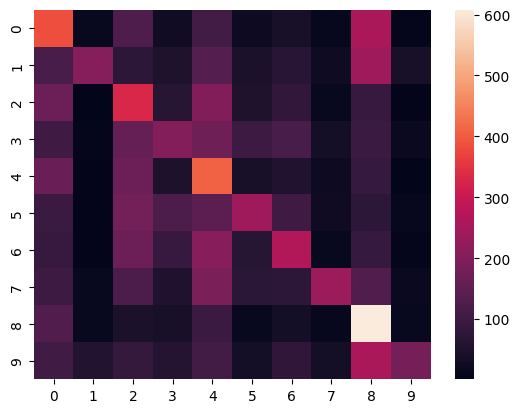

In [113]:
confusion_mat = sklearn.metrics.confusion_matrix(y_test, y_pred_knn)

seaborn.heatmap(confusion_mat)

## KNN Classifier Conclusion
- Using hyper parameters tuning we found the best parameters for KNN
- Metrics:
    1. Accuracy:  0.307
    1. F1 Score:  0.30184036504206985
    1. Precision:  0.37483192426666134
    1. Recall:  0.307
- Overall, not very good for CIFAR-10